# Notebook_03 Veri Hikayesi Anlatımı - Açık uçlu analiz

Bu notebook’ta, ilçeler arası elektrik tüketim düzeylerinin farklılaşmasına yol açan unsurlar; hesap sınıfı dağılımları, mevsimsellik etkileri ve müşteri profilleri çerçevesinde karşılaştırmalı olarak incelenmiştir. İlçe bazında elde edilen bulgular, çeşitli veri görselleştirmeleri aracılığıyla analiz edilerek yorumlanmıştır.

Ayrıca, tüketim miktarı ve ödeme davranışı göstergeleri esas alınarak müşteriler belirli segmentlere ayrılmış; her bir segmentin temel özellikleri tanımlanmış ve bulgular elde edilmiştir.


In [417]:
# necessary libraries
import numpy as np  # numerical operations 
import pandas as pd  # data manipulation 
import seaborn as sns  # visualization
import matplotlib.pyplot as plt  # visualizatio

In [418]:
# Grafik stili ayarları
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [419]:
# Temizlenmiş veri setlerinin Parquet formatından hızlı bir şekilde yüklenmesi
df_tahsilat = pd.read_parquet("df_tahsilat_clean.parquet")
df_tahsilat_1 = pd.read_parquet("df_tahsilat_1_clean.parquet")
df_tahakkuk = pd.read_parquet("df_tahakkuk_clean.parquet")



### PROBLEM TANIMI - İLÇE KARŞILAŞTIRMA ANALİZİ



PROBLEM:
Elektrik dağıtım şirketimizde 3 farklı ilçe bulunmaktadır.
Bu ilçeler arasında tüketim davranışları, ödeme alışkanlıkları ve 
müşteri profilleri açısından önemli farklılıklar olduğu gözlemlenmektedir.

AMAÇ:
İlçeler arası farklılıkları anlamak ve her ilçe için özelleştirilmiş 
stratejiler geliştirmek.

ANALİZ SORULARI:
1. Hangi ilçede ortalama tüketim daha yüksek?
2. Mevsimsellik her ilçeyi nasıl etkiliyor?
3. Hesap sınıfı dağılımları ilçeler arasında nasıl değişiyor?
4. Hangi ilçede ödeme disiplini daha iyi?
5. Aykırı tüketimler hangi ilçede daha yaygın?


In [420]:

# Tarih bilgisinden ay değişkeninin türetilmesi
df_tahakkuk['ay'] = df_tahakkuk['mali_yil_donem'].dt.month

# Ay bilgisi kullanılarak gözlemlerin mevsimsel kategorilere ayrılması
df_tahakkuk['mevsim'] = df_tahakkuk['ay'].map({
    12: 'Kış', 1: 'Kış', 2: 'Kış',
    3: 'İlkbahar', 4: 'İlkbahar', 5: 'İlkbahar',
    6: 'Yaz', 7: 'Yaz', 8: 'Yaz',
    9: 'Sonbahar', 10: 'Sonbahar', 11: 'Sonbahar'
})

#### Ay Değişkeninin Türetilmesi
Zaman serisi niteliği taşıyan `mali_yil_donem` değişkeninden ay bilgisi ayrıştırılmıştır.

Bu adımın amacı:
- Zaman boyutunu daha analiz edilebilir hale getirmek,
- Aylık ve mevsimsel örüntülerin incelenmesine zemin hazırlamaktır.

`.dt.month` ifadesi, tarih bilgisinden yalnızca ay bileşenini çekerek
her gözleme sayısal bir ay değeri atar.

In [20]:
df_tahakkuk.head()

,il,ilce,sozlesme_hesap_no,mali_yil_donem,fatura_tarihi,kayit_tarihi,vade_tarihi,hesap_sinifi,Hesap Sınıfı,kwh,ay,mevsim
0,AMASYA,HAMAMÖZÜ,917576806,2023-01-01,2023-01-12,2023-03-06,2023-01-23,M001,Mesken,1.79,1,Kış
1,AMASYA,HAMAMÖZÜ,917576806,2023-01-01,2023-02-09,2023-05-11,2023-02-20,M001,Mesken,2.60,1,Kış
2,AMASYA,HAMAMÖZÜ,917576806,2023-02-01,2023-02-09,2023-05-11,2023-02-20,M001,Mesken,1.23,2,Kış
3,AMASYA,HAMAMÖZÜ,917576806,2023-02-01,2023-03-10,2023-05-11,2023-03-20,M001,Mesken,2.56,2,Kış
4,AMASYA,HAMAMÖZÜ,917576806,2023-03-01,2023-03-10,2023-05-11,2023-03-20,M001,Mesken,1.35,3,İlkbahar


In [376]:
# Benzersiz ilçe listesinin alınması
ilceler = df_tahakkuk['ilce'].unique()

In [27]:
# =========================================
# TEMEL İSTATİSTİKLER VE TANIMLAYICI ANALİZ


print("\n TEMEL İSTATİSTİKLER")
print("="*70)

# İlçe bazında kWh değişkeni için temel tanımlayıcı istatistiklerin hesaplanması
ilce_ozet = df_tahakkuk.groupby('ilce',observed=True)['kwh'].agg([
    ('Ortalama', 'mean'),
    ('Medyan', 'median'),
    ('Std Sapma', 'std'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('Toplam Kayıt', 'count')
]).round(2)

print(ilce_ozet)


 TEMEL İSTATİSTİKLER
              Ortalama  Medyan  Std Sapma       Min        Max  Toplam Kayıt
ilce                                                                        
GÖYNÜCEK         89.67   45.09     742.28  -4208.64  105687.69        295223
GÜMÜŞHACIKÖY     97.34   48.31    1077.76 -25370.64  153575.73        765657
HAMAMÖZÜ         70.87   40.56     389.22  -1242.99   25941.60        124818


#### Analizin Amacı
Bu bölümde, kWh tüketim değişkeninin **ilçe bazında dağılımı ve temel özellikleri**
incelenmektedir. Amaç, ilçeler arasındaki tüketim seviyeleri ve değişkenliklerin
karşılaştırılabilir hale getirilmesidir.


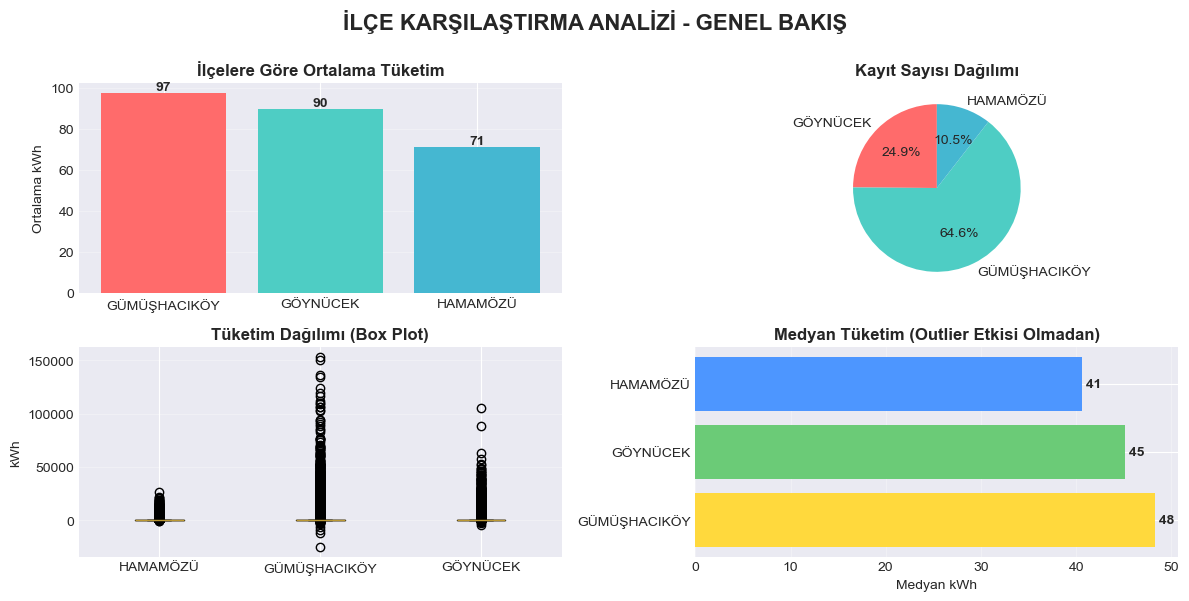

In [377]:
# ==================================
# İLÇELERİN GENEL KARŞILAŞTIRMASI


fig, ax = plt.subplots(2, 2, figsize=(12, 6))

# ==================================
# 1. Ortalama tüketim karşılaştırması

ortalama_tuketim = df_tahakkuk.groupby('ilce', observed=True)['kwh'].mean().sort_values(ascending=False)
bars = ax[0, 0].bar(ortalama_tuketim.index, ortalama_tuketim.values, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
ax[0, 0].set_title('İlçelere Göre Ortalama Tüketim', fontweight='bold', fontsize=12)
ax[0, 0].set_ylabel('Ortalama kWh')
ax[0, 0].grid(axis='y', alpha=0.3)

# Bar değerlerinin grafik üzerine eklenmesi
for bar in bars:
    height = bar.get_height()
    ax[0, 0].text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.0f}',
            ha='center', va='bottom', fontweight='bold')

# ==================================
# 2. Kayıt Sayısı Dağılımı

kayıt_sayisi = df_tahakkuk.groupby('ilce', observed = True).size()
patches, texts, autotexts = ax[0, 1].pie(kayıt_sayisi.values, labels=kayıt_sayisi.index, 
                                      autopct='%1.1f%%', startangle=90,
                                      colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])

ax[0, 1].set_title('Kayıt Sayısı Dağılımı', fontweight='bold', fontsize=12)


# ==================================
# 3. Tüketim dağılımının boxplot grafiği ile gösterimi

veriler = [
    df_tahakkuk[df_tahakkuk['ilce'] == ilce]['kwh']
    for ilce in ilceler
]

ax[1, 0].boxplot(veriler, tick_labels=ilceler, showfliers=True)

ax[1, 0].set_title('Tüketim Dağılımı (Box Plot)', fontweight='bold', fontsize=12)
ax[1, 0].set_ylabel('kWh')
ax[1, 0].grid(axis='y', alpha=0.3)

# ==================================
# 4. Medyan Tüketim Karşılaştırması

medyan_tuketim = df_tahakkuk.groupby('ilce',observed = True)['kwh'].median().sort_values(ascending=False)
ax[1, 1].barh(medyan_tuketim.index, medyan_tuketim.values, color=['#FFD93D', '#6BCB77', '#4D96FF'])
ax[1, 1].set_title('Medyan Tüketim (Outlier Etkisi Olmadan)', fontweight='bold', fontsize=12)
ax[1, 1].set_xlabel('Medyan kWh')
ax[1, 1].grid(axis='x', alpha=0.3)

# Medyan değerlerin grafik üzerine eklenmesi
for i, (idx, val) in enumerate(medyan_tuketim.items()):
    ax[1, 1].text(val, i, f' {val:.0f}', va='center', fontweight='bold')


# ==================================
# İlçe karşılaştırma analizinin genel başlığı

plt.suptitle('İLÇE KARŞILAŞTIRMA ANALİZİ - GENEL BAKIŞ', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('01_ilce_genel_bakis.png', dpi=300, bbox_inches='tight')
plt.show()


### Bulgular

##### Ortalama Tüketim (Merkezî Eğilim)

İlçelere göre ortalama elektrik tüketimi incelendiğinde:

- **Gümüşhacıköy**, yaklaşık **97 kWh** ile en yüksek ortalama tüketime sahiptir.
- **Göynücek**, yaklaşık **90 kWh** ile ikinci sırada yer almaktadır.
- **Hamamözü**, yaklaşık **71 kWh** ile belirgin biçimde daha düşük bir ortalamaya sahiptir.

Bu bulgular, ilçeler arasında ortalama tüketim düzeyleri açısından anlamlı bir seviye farkı bulunduğuna işaret etmektedir. Ancak ortalama değerlerin, yüksek tüketimli uç gözlemlerden (outlier) etkilenmeye açık olması nedeniyle, bu farkların tek başına “tipik kullanıcı” davranışını tam olarak yansıttığını söylemek temkinli bir yaklaşım gerektirmektedir.

---

##### Kayıt Sayısı Dağılımı

Kayıtların ilçelere göre dağılımı şu şekildedir:

- **Gümüşhacıköy**, toplam kayıtların yaklaşık **%65’ini** oluşturmaktadır.
- **Göynücek**, yaklaşık **%25** paya sahiptir.
- **Hamamözü**, yalnızca **%10–11** seviyesindedir.

---

##### Tüketim Dağılımı – Box Plot (Dağılım ve Aykırı Değerler)

Tüketim dağılımları incelendiğinde:

- **Gümüşhacıköy ve Göynücek’te**
  - Çok sayıda yüksek tüketimli uç değer bulunmaktadır.
  - Dağılım **sağa çarpık** bir yapı sergilemektedir.
- **Hamamözü’nde**
  - Daha dar bir dağılım,
  - Daha sınırlı uç değerler gözlemlenmektedir.

Yüksek ortalama tüketim değerlerinin temel nedeni, ilçelerdeki az sayıda ancak çok yüksek tüketim gerçekleştiren abonelerdir. Özellikle Gümüşhacıköy’de gözlenen bu yapı, sanayi veya ticari kullanım ya da büyük ölçekli aboneler gibi özel tüketici segmentlerinin varlığına işaret edebilir.

---

##### Medyan Tüketim ( Uç Değerlerden Arındılırmış Karşılaştırma)

Medyan tüketim değerleri şu şekildedir:

- **Gümüşhacıköy:** ≈ **48 kWh**
- **Göynücek:** ≈ **45 kWh**
- **Hamamözü:** ≈ **41 kWh**

Medyan değerlerin birbirine oldukça yakın olması, ilçeler arası ortalama farklarının büyük ölçüde uç tüketicilerden kaynaklandığını göstermektedir. Bu durum, tipik bir abonenin tüketim davranışının ilçeler arasında radikal biçimde ayrışmadığına işaret etmektedir.

---

#### Genel Değerlendirme

Politika geliştirme, fiyatlama stratejileri veya risk analizi gibi karar süreçlerinde, ortalama değerler yerine **medyan ve segment bazlı analizlerin** tercih edilmesi daha sağlıklı sonuçlar üretebilir. Özellikle **Gümüşhacıköy’de yüksek tüketimli abonelerin ayrı bir segment olarak ele alınması**, **Hamamözü’nde ise daha homojen ancak düşük tüketimli bir kullanıcı profiline odaklanılması** analitik açıdan anlamlı görünmektedir.



In [378]:
# =======================
# MEVSİMSELLİK ANALİZİ


print("\n MEVSİMSELLİK ETKİSİ")
print("="*50)

# İlçe ve mevsim kırılımında ortalama kWh değerlerinin hesaplanması
mevsim_analiz = df_tahakkuk.groupby(['ilce', 'mevsim'], observed=True)['kwh'].mean().unstack()

# Mevsimlerin analizde kullanılacak sıraya göre düzenlenmesi
mevsim_analiz = mevsim_analiz[['İlkbahar', 'Yaz', 'Sonbahar', 'Kış']]  # Sıralama
print(mevsim_analiz.round(2))

# Kış ve yaz dönemleri arasındaki tüketim farkının oransal olarak hesaplanması
print("\nKış/Yaz Tüketim Oranları:")

for ilce in ilceler:
    
    kis_ort = mevsim_analiz.loc[ilce, 'Kış']
    yaz_ort = mevsim_analiz.loc[ilce, 'Yaz']
    oran = (kis_ort / yaz_ort - 1) * 100
    
    print(
        f"{ilce}: Kış aylarında %{oran:.1f} "
        f"{'artış' if oran > 0 else 'azalış'}"
    )


 MEVSİMSELLİK ETKİSİ
mevsim        İlkbahar     Yaz  Sonbahar    Kış
ilce                                           
GÖYNÜCEK         77.66  129.04     79.70  69.80
GÜMÜŞHACIKÖY     89.60  121.49     87.55  88.45
HAMAMÖZÜ         67.41   75.62     70.62  70.07

Kış/Yaz Tüketim Oranları:
HAMAMÖZÜ: Kış aylarında %-7.3 azalış
GÜMÜŞHACIKÖY: Kış aylarında %-27.2 azalış
GÖYNÜCEK: Kış aylarında %-45.9 azalış


#### Mevsimsellik Etkisi Analizi
Bu bölümde, kWh tüketiminin **mevsimlere göre nasıl değiştiği**
ilçe bazında incelenmektedir. Amaç, tüketimdeki dönemsel farklılıkları
açık biçimde ortaya koymaktır.


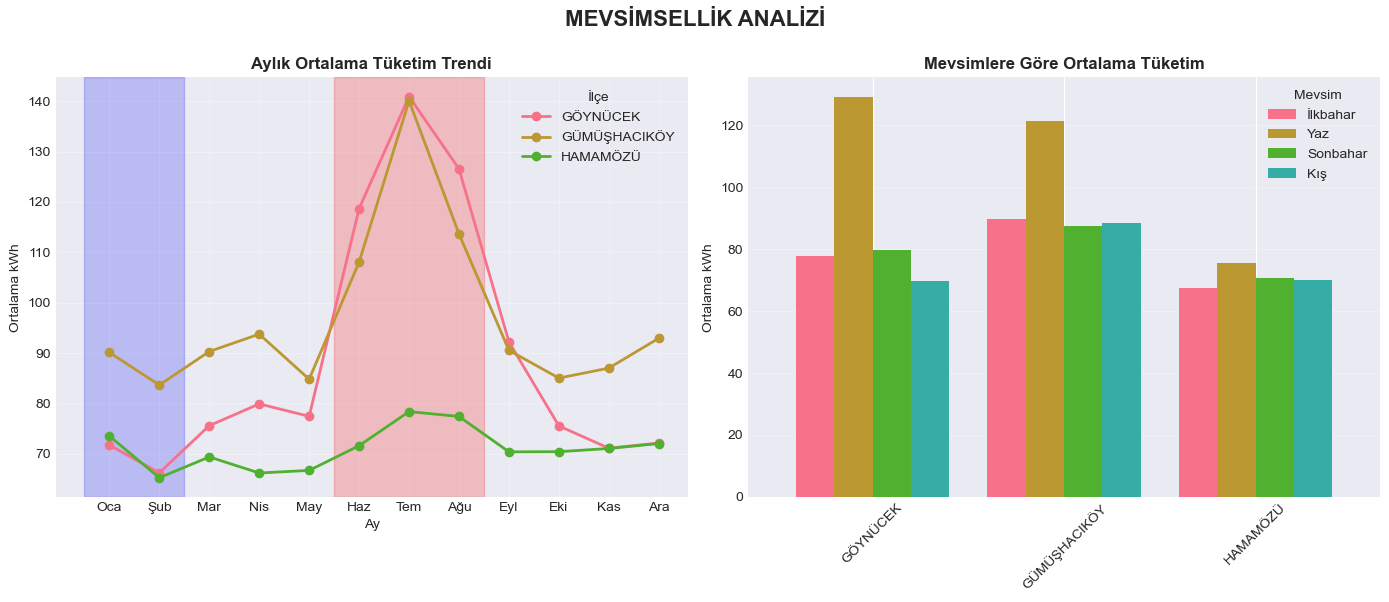

In [379]:
# =======================
# MEVSİMSELLİK ANALİZİ


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Aylık tüketim trendinin gösterimi
aylik_ort = df_tahakkuk.groupby(['ilce', 'ay'],observed=True)['kwh'].mean().unstack().T
aylik_ort.plot(ax=axes[0], marker='o', linewidth=2, markersize=6)
axes[0].set_title('Aylık Ortalama Tüketim Trendi', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Ay')
axes[0].set_ylabel('Ortalama kWh')
axes[0].set_xticks(range(1, 13))
axes[0].set_xticklabels(['Oca', 'Şub', 'Mar', 'Nis', 'May', 'Haz', 
                     'Tem', 'Ağu', 'Eyl', 'Eki', 'Kas', 'Ara'])
axes[0].legend(title='İlçe', loc='best')
axes[0].grid(True, alpha=0.3)

# Kış ve yaz aylarının görsel olarak vurgulanması
axes[0].axvspan(0.5, 2.5, alpha=0.2, color='blue')
axes[0].axvspan(5.5, 8.5, alpha=0.2, color='red')


# 2. Mevsimsel ortalama tüketimlerin karşılaştırılması
mevsim_analiz.plot(kind='bar', ax=axes[1], width=0.8)
axes[1].set_title('Mevsimlere Göre Ortalama Tüketim', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Ortalama kWh')
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Mevsim', loc='best')
axes[1].grid(axis='y', alpha=0.3)


# Mevsimsellik analizine ilişkin genel başlık
plt.suptitle('MEVSİMSELLİK ANALİZİ', fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('02_mevsimsellik_analizi.png', dpi=300, bbox_inches='tight')
plt.show()

### Bulgular

##### Aylık Ortalama Tüketim Trendi

Aylık ortalama elektrik tüketimi trendi incelendiğinde, üç ilçede de **belirgin bir mevsimsel dalgalanma** olduğu görülmektedir. Genel olarak tüketim düzeyleri kış aylarında görece düşük seyrederken, yaz aylarında belirgin biçimde artmaktadır.

- **Gümüşhacıköy ve Göynücek’te**, özellikle **Haziran–Ağustos** döneminde keskin bir tüketim artışı gözlemlenmektedir.
- **Temmuz ayı**, her iki ilçe için de yılın en yüksek ortalama tüketim seviyesinin görüldüğü dönemdir.
- **Hamamözü’nde** ise aylık tüketim dalgalanmaları daha sınırlı olup, yıl genelinde daha dengeli bir seyir izlenmektedir.

Bu bulgular, yaz aylarında artan soğutma ihtiyacı, tarımsal sulama veya mevsimsel ekonomik faaliyetlerin, özellikle Gümüşhacıköy ve Göynücek’te tüketimi yukarı yönlü etkilediğini düşündürmektedir.

---

##### Mevsimlere Göre Ortalama Tüketim

Mevsim bazında ortalama tüketim değerleri incelendiğinde şu eğilimler öne çıkmaktadır:

- **Yaz mevsimi**, üç ilçede de en yüksek ortalama tüketimin gerçekleştiği dönemdir.
  - Göynücek’te yaz aylarında ortalama tüketim yaklaşık **130 kWh** seviyesine ulaşmaktadır.
  - Gümüşhacıköy’de yaz ortalaması yaklaşık **120 kWh** civarındadır.
  - Hamamözü’nde ise yaz tüketimi yaklaşık **75 kWh** ile diğer ilçelere kıyasla daha sınırlıdır.
- **Kış ve sonbahar mevsimlerinde**, ilçeler arası tüketim farkları belirgin biçimde azalmaktadır.
- **İlkbahar**, yaz öncesi geçiş dönemi olarak, tüketimin kademeli şekilde arttığı bir dönem niteliği taşımaktadır.

Bu yapı, ilçeler arasındaki tüketim farklarının özellikle **yaz mevsiminde belirginleştiğini**, diğer mevsimlerde ise tüketim seviyelerinin birbirine daha yakın seyrettiğini göstermektedir.

---

#### Genel Değerlendirme

Mevsimsellik açısından ilçeler karşılaştırıldığında:

- **Gümüşhacıköy ve Göynücek**, mevsimsel değişimlere daha duyarlı bir tüketim profili sergilemektedir.
- **Hamamözü**, yıl boyunca daha **homojen ve düşük oynaklığa sahip** bir tüketim yapısına sahiptir.

Bu durum, Hamamözü’nde tüketimin büyük ölçüde hane halkı kullanımına dayandığını; buna karşılık Gümüşhacıköy ve Göynücek’te mevsime bağlı faaliyetlerin (ticari, tarımsal veya hizmet sektörü kaynaklı) daha belirleyici olduğunu düşündürmektedir.


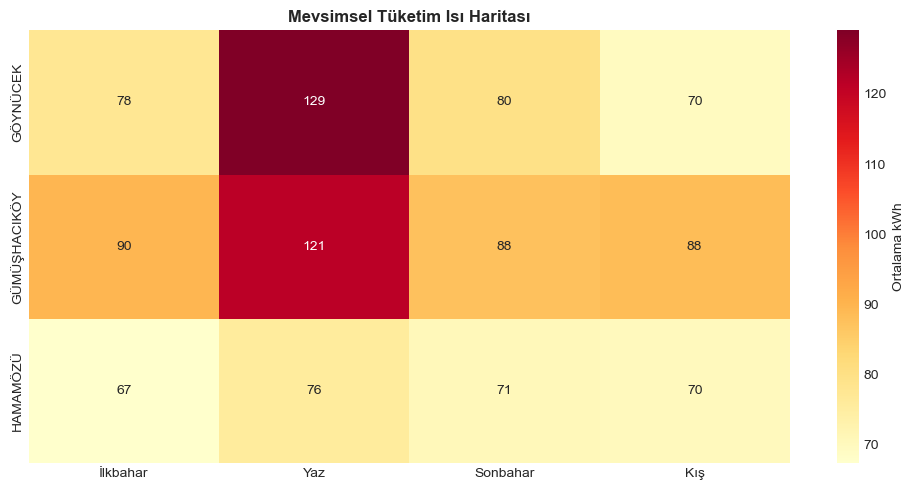

In [453]:
# Mevsimsel değişim ısı haritası

plt.figure(figsize=(10,5))

# İlçe ve mevsim kırılımında ortalama kWh değerlerinin pivot tabloya dönüştürülmesi
mevsim_pivot = df_tahakkuk.pivot_table(values='kwh', index='ilce', 
                                        columns='mevsim', aggfunc='mean',observed=True)

# Mevsimlerin analiz sırasına göre düzenlenmesi
mevsim_pivot = mevsim_pivot[['İlkbahar', 'Yaz', 'Sonbahar', 'Kış']]

# Mevsimsel tüketim farklılıklarının ısı haritası ile görselleştirilmesi
sns.heatmap(mevsim_pivot, annot=True, fmt='.0f', cmap='YlOrRd', 
            cbar_kws={'label': 'Ortalama kWh'})

plt.title('Mevsimsel Tüketim Isı Haritası', fontweight='bold', fontsize=12)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('03_mevsimsellik_ısı_haritası.png', dpi=300, bbox_inches='tight')
plt.show()

#### Özet Bulgular
- Yaz mevsimi, tüketimin yoğunlaştığı kritik dönemdir 
- Göynücek, en yüksek mevsimsel oynaklık sahiptir. 
- Gümüşhacıköy, yıl geneline yayılmış yüksek tüketim göstermektedir. 
- Hamamözü, düşük ve dengeli tüketim profili sergelemektedir.

**Not:** Göynücek'teki mevsimsellik oranında artış dikkatli,ayrıntılı ve ayrı bir analizi gerektirmektedir.


In [452]:
# ========================
#  HESAP SINIFI ANALİZİ

print("\n HESAP SINIFI ANALİZİ ")
print("="*50)

# İlçe ve hesap sınıfı kırılımında ortalama kWh ve kayıt sayılarının hesaplanması
Hesap_sınıf_analiz = df_tahakkuk.groupby(['ilce', 'Hesap Sınıfı'],observed=True).agg({
    'kwh': ['mean', 'count']
}).round(2)

print(Hesap_sınıf_analiz)



 HESAP SINIFI ANALİZİ 
                                                       kwh      
                                                      mean count
ilce     Hesap Sınıfı                                           
GÖYNÜCEK 1 SAYILI CETVELDE YER ALAN KAMU İDARESİ    368.64  2146
         Belediye                                   191.35   829
         Bina Ort Kul (Asn,Hidr,Kapıcı Dai vb.)      33.18   654
         Büyükbaş-Küçükbaş Hayvancılık              179.49  1031
         Cemevleri                                   11.81   272
...                                                    ...   ...
HAMAMÖZÜ İbadethane Isıtma/Soğutma/Lojman            69.88  1443
         İktisadi İşletmeleri Hariç Dernek ve Vkf   200.54    76
         İçme-Kullanma Suyu (Belediye)             2678.05    40
         Şantiye ve Geçici Aboneler                 500.07   402
         Şehit Aileleri ve Gaziler                   38.38   120

[93 rows x 2 columns]


#### Hesap Sınıfı Analizi
Bu bölümde, elektrik tüketiminin **hesap sınıflarına göre nasıl farklılaştığı**
ilçe bazında incelenmektedir. Amaç, konut, ticari veya diğer abone türlerinin
tüketim davranışlarını karşılaştırmalı olarak değerlendirmektir.

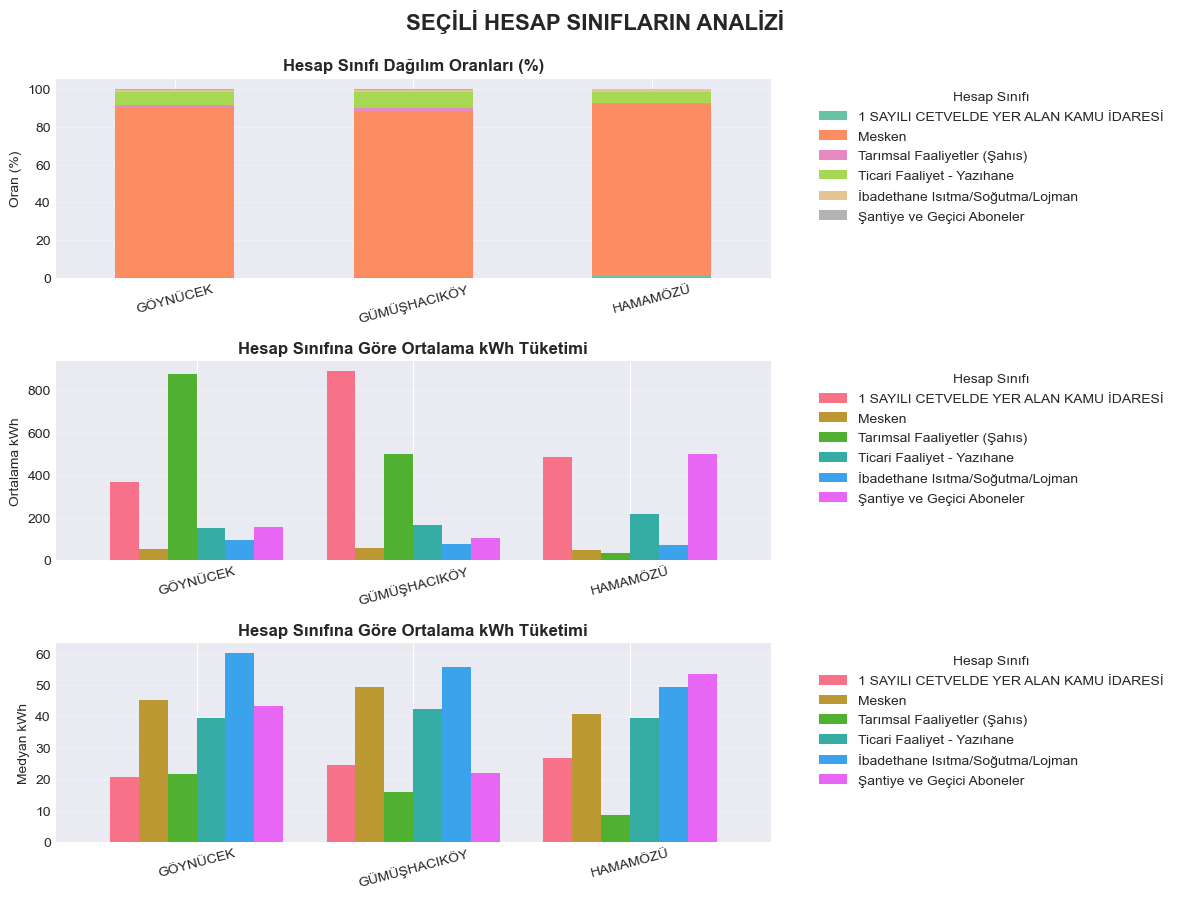

In [480]:
# ==================================
# Hesap sınıf analizi
# Belirlenen hesap sınıflarına göre inceleme

# Analizde kullanılacak hesap sınıflarının tanımlanması
istenen_siniflar = [
    "Mesken",
    "Ticari Faaliyet - Yazıhane",
    "Tarımsal Faaliyetler (Şahıs)",
    "İbadethane Isıtma/Soğutma/Lojman",
    "1 SAYILI CETVELDE YER ALAN KAMU İDARESİ",
    "Şantiye ve Geçici Aboneler"
]

# Veri setinin yalnızca seçili hesap sınıflarını içerecek şekilde filtrelenmesi
df_analiz = df_tahakkuk[df_tahakkuk['Hesap Sınıfı'].isin(istenen_siniflar)].copy()


fig, axes = plt.subplots(3, 1, figsize=(12, 9))

# ==================================
# 1. Hesap sınıfı oranlarının hesaplanması ve gösterimi
hesap_oran = df_analiz.groupby(['ilce', 'Hesap Sınıfı'],observed=True).size().unstack(fill_value=0)

# İlçe bazında yüzde dağılımların hesaplanması
hesap_oran_pct = hesap_oran.div(hesap_oran.sum(axis=1), axis=0) * 100
ax1 = axes[0]

hesap_oran_pct.plot(kind='bar', stacked=True, ax=ax1, colormap='Set2')
ax1.set_title('Hesap Sınıfı Dağılım Oranları (%)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Oran (%)')
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=15)
ax1.legend(title='Hesap Sınıfı', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(axis='y', alpha=0.3)

# ==================================
# 2. Hesap sınıfına göre ortalama tüketimlerin hesaplanması ve karşılaştırılması

ax2 = axes[1]

hesap_tuketim = df_analiz.groupby(['ilce', 'Hesap Sınıfı'],observed=True)['kwh'].mean().unstack()

hesap_tuketim.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('Hesap Sınıfına Göre Ortalama kWh Tüketimi', fontweight='bold', fontsize=12)
ax2.set_ylabel('Ortalama kWh')
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=15)
ax2.legend(title='Hesap Sınıfı', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(axis='y', alpha=0.3)

# ==================================
# 2. Hesap sınıfına göre median tüketim hesaplanması ve karşılaştırılması
ax3 = axes[2]

hesap_tuketim = df_analiz.groupby(['ilce', 'Hesap Sınıfı'],observed=True)['kwh'].median().unstack()

hesap_tuketim.plot(kind='bar', ax=ax3, width=0.8)
ax3.set_title('Hesap Sınıfına Göre Ortalama kWh Tüketimi', fontweight='bold', fontsize=12)
ax3.set_ylabel('Medyan kWh')
ax3.set_xlabel('')
ax3.tick_params(axis='x', rotation=15)
ax3.legend(title='Hesap Sınıfı', bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.grid(axis='y', alpha=0.3)


# Seçili hesap sınıflarına ilişkin genel karşılaştırma başlığı
plt.suptitle('SEÇİLİ HESAP SINIFLARIN ANALİZİ', fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig('04_hesap_sınıf_analiz.png', dpi=300, bbox_inches='tight')
plt.show()

#### Bulgular

##### Hesap Sınıfı Dağılım Oranları

Tüm ilçelerin hesap sınıf bazında yakın oranlarda dağılımına sahip olduğu gözlemleniyor. 

---

##### İlçeler Arası Yapısal Farklılıklar

Hesap sınıfına göre ortalama ve medyan kWh tüketim değerleri birlikte incelendiğinde, ilçeler arasında **grafik sıralamalarının belirgin biçimde değiştiği** görülmektedir.

- Ortalama , tüm gözlemleri dikkate alan ve yüksek tüketimli uç değerlerden doğrudan etkilenen bir ölçüdür.
- Medyan, dağılımın ortasındaki değeri temsil eder ve uç gözlemlere karşı dayanıklıdır.

Grafikler incelendiğinde, özellikle **Gümüşhacıköy** örneğinde bu fark net biçimde ortaya çıkmaktadır:

- **Ortalama tüketim grafiğinde**, *1 Sayılı Cetvelde Yer Alan Kamu İdareleri* sınıfı Gümüşhacıköy’de en yüksek tüketim değerine sahiptir.
- Buna karşılık **medyan tüketim grafiğinde**, aynı hesap sınıfı **dördüncü sıraya gerilemektedir**.

Bu durum, Gümüşhacıköy’de kamu idarelerine ait:
- **Az sayıda fakat çok yüksek tüketimli** bazı abonelerin bulunduğunu,

Benzer biçimde, Göynücek’de tarımsal faaliyetler (şahıs)'e ait:
- **Az sayıda fakat çok yüksek tüketimli** bazı abonelerin bulunduğunu,

Ayrıca, Hamamözü şantiye/geçici hesap sınıfı için:

- Hem ortalama tüketim hem medyan tüketim diğer ilçelerden ayrılması bu ilçeye özgü bir şantiye/geçici hesap sınıfı bir
  profilin varlığını göstermektedir.
---

#### Genel Değerlendirme

- Özellikle **Gümüşhacıköy** gibi ilçelerde, yüksek tüketimli **kamu veya tarımsal** abonelerin **ayrı bir segment olarak ele alınması**, daha sağlıklı analiz ve politika geliştirilmesine katkı sağlayacaktır.

- Benzer şekilde **Göynücek** ilçesinde **yüksek tüketimli tarımsal** abonelerin ve **Hamamözü** ilçesindeki **şantiye/geçici** abonelerin **ayrı bir segment olarak ele alınması**, daha sağlıklı analiz ve politika geliştirilmesine katkı sağlayacaktır.


In [126]:
# ===================
# ÖDEME DAVRANIŞI

print("\nÖDEME DAVRANIŞI")
print("=" * 50)

# Zamanında ödeme kapsamına giren tahsilat sütunlarının tanımlanması
zamaninda_cols = [
    'Son Ödeme Tarihinden Önceki Tahsilat',
    'Son Ödeme Tarihindeki Tahsilat'
]

# Gecikmeli ödeme kapsamına giren tahsilat sütunlarının tanımlanması
gec_cols = [
    'Son Ödeme (1)', 'Son Ödeme (2)', 'Son Ödeme (6-10)',
    'Son Ödeme (10-20)', 'Son Ödeme (20-30)',
    'Son Ödeme (30-60)', 'Son Ödeme (60-90)',
    'Son Ödeme (90-120)', 'Son Ödeme (120-150)',
    'Son Ödeme (150-180)', 'Son Ödeme (180+)'
]

# İlçe bazında zamanında ve gecikmeli ödeme tutarlarının toplanması
odeme_analiz = (
    df_tahsilat_1
    .groupby('İlçe', observed=True)[zamaninda_cols + gec_cols]
    .sum()
)

# İlçe bazında zamanında ödeme toplamlarının hesaplanması
odeme_analiz['Zamanında'] = odeme_analiz[zamaninda_cols].sum(axis=1)

# İlçe bazında gecikmeli ödeme toplamlarının hesaplanması
odeme_analiz['Geç'] = odeme_analiz[gec_cols].sum(axis=1)

# Toplam tahsilat tutarlarının hesaplanması
odeme_analiz['Toplam'] = odeme_analiz['Zamanında'] + odeme_analiz['Geç']

# Zamanında ödeme oranlarının yüzde olarak hesaplanması
odeme_analiz['Zamanında_Oran'] = (
    odeme_analiz['Zamanında'] / odeme_analiz['Toplam'] * 100
).round(2)

print("\nİlçelere Göre Zamanında Ödeme Oranları (%):")

print(
    odeme_analiz[['Zamanında_Oran']]
    .sort_values('Zamanında_Oran', ascending=False)
)


ÖDEME DAVRANIŞI

İlçelere Göre Zamanında Ödeme Oranları (%):
              Zamanında_Oran
İlçe                        
TAŞOVA                 71.60
GÜMÜŞHACIKÖY           69.06
HAMAMÖZÜ               68.48
GÖYNÜCEK               62.42


#### Ödeme Davranış Analizi

Analizin Amacı:

Bu bölümde, müşterilerin **zamanında** ve **gecikmeli** ödeme davranışları
ilçe bazında analiz edilmektedir.  
Amaç, ödeme disiplininin hangi ilçelerde daha güçlü veya zayıf olduğunu belirlemektir.


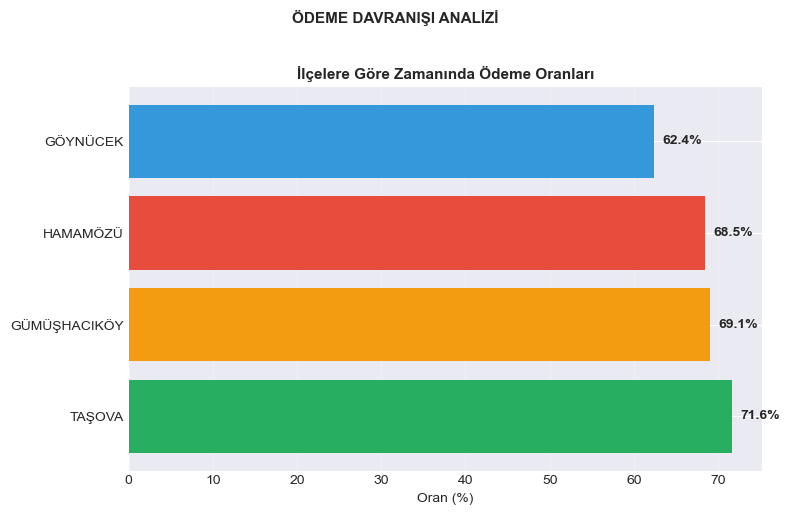

In [484]:
# ====================
# ÖDEME DAVRANIŞI

fig, ax = plt.subplots(figsize=(8, 5))

# Zamanında ödeme oranlarının ilçe bazında görselleştirilmesi
odeme_sira = odeme_analiz['Zamanında_Oran'].sort_values(ascending=False)

# Zamanında ödeme oranlarının ilçe bazında görselleştirilmesi
bars = ax.barh(range(len(odeme_sira)), odeme_sira.values, 
                color=['#27AE60', '#F39C12', '#E74C3C', '#3498DB'][:len(odeme_sira)])
ax.set_yticks(range(len(odeme_sira)))
ax.set_yticklabels(odeme_sira.index)
ax.set_title('İlçelere Göre Zamanında Ödeme Oranları', fontweight='bold', fontsize=11)
ax.set_xlabel('Oran (%)')
ax.grid(axis='x', alpha=0.3)

# Oran değerlerinin çubuk grafik üzerine eklenmesi
for i, val in enumerate(odeme_sira.values):
    ax.text(val + 1, i, f'{val:.1f}%', va='center', fontweight='bold')

plt.suptitle('ÖDEME DAVRANIŞI ANALİZİ', fontsize=11, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('05_odeme_davranisi.png', dpi=300, bbox_inches='tight')
plt.show()

#### Bulgular


Zamanında ödeme oranları arasındaki farklar yaklaşık **7 puanlık bir bant** içerisinde yer almaktadır. ( Taşova bu analize geneline dahil edilmediği için ayrı tutulmuştur.)




### PROBLEM TANIMI - MÜŞTERİ SEGMENTASYONU ANALİZİ


PROBLEM:
Elektrik dağıtım şirketimizde binlerce müşteri bulunmaktadır. Her müşteriye 
tek tip hizmet sunmak hem maliyetli hem de verimsizdir. 

Bazı müşteriler yüksek tüketim yapıp düzenli ödüyor, bazıları düşük tüketimle 
geç ödüyor, bazıları ise orta seviyede hem tüketim hem ödeme yapıyor.

AMAÇ:
Müşterileri tüketim miktarı ve ödeme davranışına göre anlamlı gruplara ayırarak:
- Her grup için özelleştirilmiş stratejiler geliştirmek
- Kaynak tahsisini optimize etmek
- Müşteri memnuniyetini artırmak
- Tahsilat performansını iyileştirmek

ANALİZ SORULARI:
1. Müşteriler tüketim davranışına göre kaç gruba ayrılabilir?
2. Her grubun ödeme disiplini nasıl?
3. Hangi grup en karlı, hangisi riskli?
4. Her grup için hangi stratejiler uygulanmalı?
5. Segmentler ilçeler arasında nasıl dağılıyor?


In [421]:
# =====================
# VERİ HAZIRLAMA

print("\n VERİ HAZIRLAMA")
print("="*50)

# Tahakkuk tablosu üzerinden sözleşme bazında tüketim özelliklerinin oluşturulması
tuketim_ozellikleri = df_tahakkuk.groupby('sozlesme_hesap_no').agg({
    'kwh': ['mean', 'median', 'std', 'min', 'max', 'sum'],
    'mali_yil_donem': 'count'  # Fatura sayısı
}).reset_index()

# Türetilen değişkenlere ait kolon isimlerinin düzenlenmesi
tuketim_ozellikleri.columns = ['sozlesme_hesap_no', 'ort_tuketim', 'medyan_tuketim', 
                                 'std_tuketim', 'min_tuketim', 'max_tuketim', 
                                 'toplam_tuketim', 'fatura_sayisi']
tuketim_ozellikleri.head()


 VERİ HAZIRLAMA


,sozlesme_hesap_no,ort_tuketim,medyan_tuketim,std_tuketim,min_tuketim,max_tuketim,toplam_tuketim,fatura_sayisi
0,1000201265,14.688846,0.805,22.916149,0.00,86.06,381.91,26
1,1000410036,72.341026,68.990,35.019237,0.00,139.64,2821.30,39
2,1000551498,87.230164,87.680,25.593035,0.00,146.22,5321.04,61
3,100060700,45.084516,43.550,14.542531,5.44,73.70,1397.62,31
4,1000761630,85.055645,85.005,15.860309,47.94,121.63,5273.45,62


#### Sözleşme Hesap No Bazında Tüketim Özellikleri
Bu adımda tahakkuk verisi sözleşme bazında gruplanarak müşterilerin
tüketim davranışını temsil eden özet değişkenler türetilmiştir.
Ortalama, medyan, standart sapma, minimum–maksimum ve toplam kWh değerleri
ile birlikte fatura sayısı hesaplanarak her sözleşme için
çok boyutlu bir tüketim profili oluşturulmuştur.

In [422]:
# =====================
# ÖDEME ÖZELLİKLERİ

# Tahsilat_1 tablosu üzerinden ödeme davranışına ilişkin değişkenlerin oluşturulması

# Zamanında ödeme kapsamındaki tahsilat kolonlarının tanımlanması
zamaninda_cols = ['Son Ödeme Tarihinden Önceki Tahsilat', 'Son Ödeme Tarihindeki Tahsilat']

# Gecikmeli ödeme kapsamındaki tahsilat kolonlarının tanımlanması
gec_cols = ['Son Ödeme (1)', 'Son Ödeme (2)', 'Son Ödeme (6-10)', 'Son Ödeme (10-20)', 
            'Son Ödeme (20-30)', 'Son Ödeme (30-60)', 'Son Ödeme (60-90)', 
            'Son Ödeme (90-120)', 'Son Ödeme (120-150)', 'Son Ödeme (150-180)', 'Son Ödeme (180+)']

# Sözleşme bazında tahakkuk ve tahsilat tutarlarının toplanması
odeme_ozellikleri = (
    df_tahsilat_1
    .groupby('Söz.hsp.(bağımsız)')[['Tahakkuk Tutar'] + zamaninda_cols + gec_cols]
    .sum()
    .reset_index()
)

# Zamanında ödeme toplamlarının hesaplanması
odeme_ozellikleri['zamaninda_toplam'] = odeme_ozellikleri[zamaninda_cols].sum(axis=1)

# Gecikmeli ödeme toplamlarının hesaplanması
odeme_ozellikleri['gec_toplam'] = odeme_ozellikleri[gec_cols].sum(axis=1)

# Toplam tahsilat tutarlarının hesaplanması
odeme_ozellikleri['toplam_tahsilat'] = odeme_ozellikleri['zamaninda_toplam'] + odeme_ozellikleri['gec_toplam']


odeme_ozellikleri.head()

,Söz.hsp.(bağımsız),Tahakkuk Tutar,Son Ödeme Tarihinden Önceki Tahsilat,Son Ödeme Tarihindeki Tahsilat,Son Ödeme (1),Son Ödeme (2),Son Ödeme (6-10),Son Ödeme (10-20),Son Ödeme (20-30),Son Ödeme (30-60),Son Ödeme (60-90),Son Ödeme (90-120),Son Ödeme (120-150),Son Ödeme (150-180),Son Ödeme (180+),zamaninda_toplam,gec_toplam,toplam_tahsilat
0,1000160099,911.99,522.05,0.00,0.0,0.0,0.0,109.96,0.00,0.00,0.00,0.0,0.00,0.00,0.0,522.05,109.96,632.01
1,1000167230,1377.39,317.87,577.76,0.0,0.0,43.0,120.45,5.00,63.96,47.70,69.0,67.68,64.97,0.0,895.63,481.76,1377.39
2,1000201265,657.41,180.29,349.29,0.0,0.0,0.0,0.00,127.83,0.00,0.00,0.0,0.00,0.00,0.0,529.58,127.83,657.41
3,100029520,402.09,209.32,0.00,0.0,0.0,29.0,0.00,0.00,0.00,133.77,30.0,0.00,0.00,0.0,209.32,192.77,402.09
4,1000410036,4606.16,3192.61,1413.55,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,4606.16,0.00,4606.16


#### Ödeme Davranışı Değişkenlerinin Türetilmesi

Bu adımda Tahsilat_1 tablosu kullanılarak sözleşme hesap no bazında ödeme davranışını
yansıtan değişkenler oluşturulmuştur. Zamanında ve gecikmeli ödemeler
ayrı gruplar halinde toplanmış; her sözleşme için zamanında ödeme tutarı,
gecikmeli ödeme tutarı ve toplam tahsilat hesaplanmıştır.

Bu adımın amacı:

Abonelerin ödeme alışkanlıklarını anlamak için yeni değişkenler üretiyoruz. Fakat bu değişkenler doğrudan karşılaştırma yapmamıza yetmediği için, sonraki adımda onları aboneleri birbirleriyle kıyaslamamızı sağlayacak bir forma getireceğiz.


In [423]:
# ==================
# ÖDEME METRİKLERİ 

# Ödeme metriklerinin oluşturulması

# Zamanında ödeme oranının yüzde olarak hesaplanması
odeme_ozellikleri['zamaninda_oran'] = (
    round(odeme_ozellikleri['zamaninda_toplam'] / odeme_ozellikleri['toplam_tahsilat'] * 100,2)
).fillna(0)

# Tahsilat oranının tahakkuk tutarına göre yüzde olarak hesaplanması
odeme_ozellikleri['tahsilat_orani'] = (
    round(odeme_ozellikleri['toplam_tahsilat'] / odeme_ozellikleri['Tahakkuk Tutar'] * 100,2)
).fillna(0)

# Gecikmeli ödemeler için ağırlıklı ortalama gecikme süresinin hesaplanması
odeme_ozellikleri['ort_gecikme(gun)'] = ((
    odeme_ozellikleri['Son Ödeme (1)'] * 1 +
    odeme_ozellikleri['Son Ödeme (2)'] * 2 +
    odeme_ozellikleri['Son Ödeme (6-10)'] * 8 +
    odeme_ozellikleri['Son Ödeme (10-20)'] * 15 +
    odeme_ozellikleri['Son Ödeme (20-30)'] * 25 +
    odeme_ozellikleri['Son Ödeme (30-60)'] * 45 +
    odeme_ozellikleri['Son Ödeme (60-90)'] * 75 +
    odeme_ozellikleri['Son Ödeme (90-120)'] * 105 +
    odeme_ozellikleri['Son Ödeme (120-150)'] * 135 +
    odeme_ozellikleri['Son Ödeme (150-180)'] * 165 +
    odeme_ozellikleri['Son Ödeme (180+)'] * 200
) / odeme_ozellikleri['gec_toplam'].replace(0, 1)).round(0)

# Hesaplanan metrikler sonrasında ara ödeme kolonlarının veri setinden çıkarılması
odeme_ozellikleri = odeme_ozellikleri.drop(columns=zamaninda_cols + gec_cols)

odeme_ozellikleri.head()

,Söz.hsp.(bağımsız),Tahakkuk Tutar,zamaninda_toplam,gec_toplam,toplam_tahsilat,zamaninda_oran,tahsilat_orani,ort_gecikme(gun)
0,1000160099,911.99,522.05,109.96,632.01,82.60,69.3,15.0
1,1000167230,1377.39,895.63,481.76,1377.39,65.02,100.0,74.0
2,1000201265,657.41,529.58,127.83,657.41,80.56,100.0,25.0
3,100029520,402.09,209.32,192.77,402.09,52.06,100.0,70.0
4,1000410036,4606.16,4606.16,0.00,4606.16,100.00,100.0,0.0


#### Ödeme Davranışı Metriklerinin Oluşturulması
Bu adımda sözleşme hesap no bazında ödeme performansını ölçen temel metrikler belirlenip
hesaplanmıştır. Zamanında ödeme oranı, toplam tahsilat içindeki
zamanında ödemelerin payı olarak; tahsilat oranı ise toplam tahsilatın
tahakkuk tutarına oranı şeklinde tanımlanmıştır. Ayrıca gecikmeli ödemeler
için, farklı gecikme aralıklarına ağırlık verilerek ortalama gecikme süresi
hesaplanmıştır. Hesaplama sonrasında ara tahsilat kolonları veri setinden
çıkarılarak analiz için sade bir metrik seti elde edilmiştir.

In [435]:
df_tahakkuk.groupby('sozlesme_hesap_no')['ilce'].nunique().value_counts()

ilce
1    28281
2        9
Name: count, dtype: int64

Aynı sözleşme hesap no ile 9 kayıtta iki ilçeden kayıt bulunmaktadır.

In [436]:
df_tahakkuk.groupby('sozlesme_hesap_no')['Hesap Sınıfı'].nunique().value_counts()

Hesap Sınıfı
1    27970
2      314
3        5
4        1
Name: count, dtype: int64

Aynı sözleşme hesap no ile birden fazla hesap sınıfıyla kayıt bulunmaktadır.

In [389]:
# Sözleşme bazında ilçe ve hesap sınıfı bilgilerinin eklenmesi
ilce_hesap = df_tahakkuk.groupby('sozlesme_hesap_no').agg({
    'ilce': 'first',
    'Hesap Sınıfı': 'first'
}).reset_index()

ilce_hesap.head()

,sozlesme_hesap_no,ilce,Hesap Sınıfı
0,1000201265,HAMAMÖZÜ,Mesken
1,1000410036,GÜMÜŞHACIKÖY,Mesken
2,1000551498,GÖYNÜCEK,Mesken
3,100060700,GÖYNÜCEK,Ticari Faaliyet - Yazıhane
4,1000761630,GÖYNÜCEK,Mesken


#### Sözleşme Bazında İlçe ve Hesap Sınıfı Bilgisinin Eşleştirilmesi
Bu adımda tahakkuk verisi sözleşme bazında gruplanarak her sözleşme için
ilçe ve hesap sınıfı bilgisi atanmıştır. `first` yöntemi, aynı sözleşme hesap no 
ile oluşmuş olan birden fazla ilçe ve hesap sınıflarınından birini 
alması istenmiştir. 

### BULGULAR

Analizde sözleşme bazında ilçe ve hesap sınıfı bilgileri tekilleştirilirken
aynı sözleşme numarasının birden fazla hesap sınıfı veya ilçe ile eşleştiği
sınırlı sayıda gözlem tespit edilmiştir. Bu durum, ödeme ve tüketim
davranışlarının tek bir kategori altında toplanmasına yol açarak
belirli müşteri davranışlarının analizde tam olarak yansıtılamamasına
neden olabilmektedir.

**Öneri:** Bu bulgu, yalnızca veri analizi süreçleri açısından değil; aynı zamanda iş süreçleri
açısındanda sorunlar çıkarabilir. Bu durumda şöyle bir yaklaşım gösterilebilir her müşteri için ayrı 
ve her sözleşme için ayrı ve benzersiz id ler atanarak süreçler daha sorunsuz yürütülebilir.

In [197]:
# Tahakkuk ve tahsilat veri setlerinde yer alan benzersiz müşteri sayılarının kontrol edilmesi
print(
    f" Tahakkuk veri setindeki benzersiz müşteri: {df_tahakkuk['sozlesme_hesap_no'].nunique()} \n"
    f" Tahsilat_1 veri setindeki benzersiz müşteri: {df_tahsilat_1['Söz.hsp.(bağımsız)'].nunique()} "
)

 Tahakkuk veri setindeki benzersiz müşteri: 28290 
 Tahsilat_1 veri setindeki benzersiz müşteri: 52367 


#### Soru: Tahakkuk datamdaki tüm benzersiz müşteriler tahsilat datasında bulunuyor mu?


In [390]:
# Tahakkuk ve tahsilat veri setlerinde yer alan benzersiz müşteri kümelerinin oluşturulması
tahakkuk_musteriler = set(df_tahakkuk["sozlesme_hesap_no"].unique())
tahsilat_musteriler = set(df_tahsilat_1["Söz.hsp.(bağımsız)"].unique())

# Tahakkukta yer alıp tahsilat tarafında bulunmayan müşteri kümelerinin belirlenmesi
eksik_musteriler = tahakkuk_musteriler - tahsilat_musteriler

# Tahakkuk ve tahsilat veri setleri arasındaki müşteri kapsamının kontrol edilmesi
if len(eksik_musteriler) == 0:
    print("Tahakkuk datamdaki tüm benzersiz müşteriler tahsilat datasında bulunmaktadır.")
else:
    print(f"Tahakkukta olup tahsilatta olmayan müşteri sayısı: {len(eksik_musteriler)}")

Tahakkukta olup tahsilatta olmayan müşteri sayısı: 899


#### Tahakkuk–Tahsilat Veri Kapsamı Tutarlılık Kontrolü
Bu adımda tahakkuk ve tahsilat veri setlerinde yer alan benzersiz sözleşme
numaraları karşılaştırılarak müşteri kapsamı tutarlılığı kontrol edilmiştir.
Sonuçlar, tahakkuk verisinde yer alan ancak tahsilat tarafında karşılığı
bulunmayan 899 müşteri bulunduğunu göstermektedir.


In [391]:
# ===========================
# TABLOLARIN BİRLEŞTİRİLMESİ

# Tüketim, ödeme ve ilçe hesap bilgilerinin müşteri bazında tek veri setinde toplanması

musteri_profil = pd.merge(
    tuketim_ozellikleri, 
    odeme_ozellikleri, 
    left_on='sozlesme_hesap_no', 
    right_on='Söz.hsp.(bağımsız)', 
    how='left'
).drop(columns=['Söz.hsp.(bağımsız)'])

# İlçe ve hesap sınıfı bilgilerinin müşteri profiline eklenmesi
musteri_profil = pd.merge(musteri_profil, ilce_hesap, on='sozlesme_hesap_no', how='left')


print(f"Toplam müşteri sayısı: {len(musteri_profil)}")
print(f"Özellik sayısı: {musteri_profil.shape[1]}")

musteri_profil.head()

Toplam müşteri sayısı: 28290
Özellik sayısı: 17


,sozlesme_hesap_no,ort_tuketim,medyan_tuketim,std_tuketim,min_tuketim,max_tuketim,toplam_tuketim,fatura_sayisi,Tahakkuk Tutar,zamaninda_toplam,gec_toplam,toplam_tahsilat,zamaninda_oran,tahsilat_orani,ort_gecikme(gun),ilce,Hesap Sınıfı
0,1000201265,14.688846,0.805,22.916149,0.00,86.06,381.91,26,657.41,529.58,127.83,657.41,80.56,100.00,25.0,HAMAMÖZÜ,Mesken
1,1000410036,72.341026,68.990,35.019237,0.00,139.64,2821.30,39,4606.16,4606.16,0.00,4606.16,100.00,100.00,0.0,GÜMÜŞHACIKÖY,Mesken
2,1000551498,87.230164,87.680,25.593035,0.00,146.22,5321.04,61,8782.62,3753.36,4219.82,7973.18,47.07,90.78,33.0,GÖYNÜCEK,Mesken
3,100060700,45.084516,43.550,14.542531,5.44,73.70,1397.62,31,4758.13,4012.13,746.00,4758.13,84.32,100.00,45.0,GÖYNÜCEK,Ticari Faaliyet - Yazıhane
4,1000761630,85.055645,85.005,15.860309,47.94,121.63,5273.45,62,8736.14,8736.14,0.00,8736.14,100.00,100.00,0.0,GÖYNÜCEK,Mesken


#### Müşteri Profilinin Oluşturulması (Tabloların Birleştirilmesi)
Bu adımda sözleşme bazında türetilen tüketim özellikleri, ödeme davranışı
metrikleri ve ilçe–hesap sınıfı bilgileri birleştirilerek tekil bir
müşteri profili veri seti oluşturulmuştur. Birleştirme işlemleri sol
birleştirme (left join) yöntemiyle gerçekleştirilmiş, böylece tahakkuk
verisinde yer alan ancak tahsilat verisi olmayan 899 müşterileri de analiz 
dahil edilmiştir.


In [392]:
# ====================
# EKSİK VERİ ANALİZİ

# Müşteri profili veri setinde eksik değerlerin kolon bazında kontrol edilmesi
musteri_profil.isna().sum()

sozlesme_hesap_no      0
ort_tuketim            0
medyan_tuketim         0
std_tuketim          287
min_tuketim            0
max_tuketim            0
toplam_tuketim         0
fatura_sayisi          0
Tahakkuk Tutar       899
zamaninda_toplam     899
gec_toplam           899
toplam_tahsilat      899
zamaninda_oran       899
tahsilat_orani       899
ort_gecikme(gun)     899
ilce                   0
Hesap Sınıfı           0
dtype: int64

### BULGULAR

Tahsilat verisinin eksik olması kabul edilebilir bir durum değildir. Bu nedenle bu müşteri profilleri için ayrıca değerlendirme yapılması gerekmektedir. Eksik tahsilat verileri, süreç yönetimi ya da veri üretim aşamasında bir problem olabileceğine işaret ediyor olabilir. Bu sebeple, verileri doldurmakla geçiştirmek yerine öncelikle bu eksikliğin neden oluştuğunun incelenmesi daha doğru bir yaklaşım olacaktır.


In [394]:
# Eksik değer doldurma işlemlerinde kullanılacak kolonların tanımlanması
kolonlar = [
    'Tahakkuk Tutar',
    'zamaninda_toplam',
    'gec_toplam',
    'toplam_tahsilat',
    'zamaninda_oran',
    'tahsilat_orani',
    'ort_gecikme(gun)'
]

for col in kolonlar:
    # İlçe ve hesap sınıfı kırılımına göre medyan ile doldurma
    musteri_profil[col] = musteri_profil[col].fillna(
        musteri_profil
            .groupby(['ilce', 'Hesap Sınıfı'],observed= True)[col]
            .transform('median')
    )
    
    # Sadece hesap sınıfı kırılımına göre medyan ile doldurma
    musteri_profil[col] = musteri_profil[col].fillna(
        musteri_profil.groupby('Hesap Sınıfı',observed = True)[col].transform('median')

    )
    
    # İlçe bazında genel medyan ile doldurma
    musteri_profil[col] = musteri_profil[col].fillna(
        musteri_profil.groupby('ilce',observed = True)[col].transform('median')
    )   
    

# Standart sapma değişkeni için ilçe ve hesap sınıfı kırılımında doldurma
musteri_profil['std_tuketim'] = musteri_profil['std_tuketim'].fillna(
    musteri_profil
        .groupby(['ilce', 'Hesap Sınıfı'],observed= True)[col]
        .transform('median')
    )    

#### Eksik Verini Doldurulma Yaklaşımı
Tahakkuk veri setimde yaklaşık 899 müşteriye ait tahsilat bilgisi bulunmamaktadır. 
Tahakkuk ve tahsilat tabloları left join ile birleştirilerek bu müşteriler veri setinde 
korunmuş ve eksik tahsilat alanları aynı ilçe ve hesap sınıfına ait medyan değerler ile doldurulmuştur.

sdt_tüketim içinde 287 null oluşması tahakkuk datamda tek faturaya sahip müşterilerden kaynaklanmıştır. 
Çünkü std tek veri üzerinden hesaplanamaz.

In [395]:
# Müşteri profili veri setinde eksik değerlerin kolon bazında kontrol edilmesi
musteri_profil.isna().sum()

sozlesme_hesap_no    0
ort_tuketim          0
medyan_tuketim       0
std_tuketim          0
min_tuketim          0
max_tuketim          0
toplam_tuketim       0
fatura_sayisi        0
Tahakkuk Tutar       0
zamaninda_toplam     0
gec_toplam           0
toplam_tahsilat      0
zamaninda_oran       0
tahsilat_orani       0
ort_gecikme(gun)     0
ilce                 0
Hesap Sınıfı         0
dtype: int64

### Müşteri Segmentasyonu - K-Means Algoritması


In [398]:
# Segmentasyon analizinde kullanılacak değişkenlerin seçilmesi
segmentasyon_df = musteri_profil[[
    'ort_tuketim',      # Ortalama tüketim
    'std_tuketim',      # Tüketim dalgalanması
    'zamaninda_oran',   # Zamanında ödeme oranı
    'tahsilat_orani',   # Tahsilat başarısı
    'ort_gecikme(gun)'       # Ortalama ödeme gecikmesi
]].copy()

segmentasyon_df.describe()

,ort_tuketim,std_tuketim,zamaninda_oran,tahsilat_orani,ort_gecikme(gun)
count,28290.000000,28290.000000,28290.000000,28290.000000,28290.000000
mean,98.664775,76.607149,73.233268,93.529016,17.687557
std,812.956430,836.664788,32.383999,16.098783,37.048555
min,-519.712353,0.000000,-81.930000,0.000000,-24.000000
25%,16.064821,11.114803,53.852500,94.250000,0.000000
50%,42.089257,20.606320,88.825000,100.000000,6.000000
75%,73.051193,30.607260,100.000000,100.000000,20.000000
max,54123.930000,54739.004821,126.990000,104.200000,3016.000000


#### Değişken Seçimi
Segmentasyon analizinde kullanılacak değişkenler, müşterilerin **tüketim davranışı** ve **ödeme alışkanlıklarını**
birlikte yansıtacak şekilde seçilmiştir.  
Amaç, yalnızca harcama düzeyine değil, aynı zamanda ödeme disiplinine göre de müşteri grupları oluşturmaktır.

`describe()` çıktısı ile değişkenlerin dağılımları, olası uç değerler ve ölçek farklılıkları gözlemlenmiştir.


In [399]:
# Segmentasyon değişkenlerinde uç değerlerin sınırlandırılması
for col in segmentasyon_df.columns:
    alt_sinir = segmentasyon_df[col].quantile(0.01)
    ust_sinir = segmentasyon_df[col].quantile(0.99)
    segmentasyon_df[col] = segmentasyon_df[col].clip(alt_sinir, ust_sinir)

#### Uç Değerlerin Sınırlandırılması (Winsorization)
Segmentasyon algoritmaları (özellikle K-Means), uç değerlere karşı hassastır.  
Bu nedenle her değişken için %1–%99 persentil aralığı belirlenmiş ve bu sınırların dışındaki gözlemler kırpılmıştır.

Bu işlem:
- Aykırı gözlemlerin küme merkezlerini bozmasını engeller  
- Veri setinin genel yapısını korur  

##### OPTİMAL SEGMENT SAYISINI BULMA (ELBOW METHOD)

In [400]:
# Segmentasyon değişkenlerinin standartlaştırılması K-Means için hazırlık
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(segmentasyon_df)

#### Standartlaştırma (StandardScaler)
K-Means algoritması **Öklidyen mesafe** kullandığı için değişkenlerin ölçekleri kritik önemdedir.

Bu adımda:
- Her değişkenin ortalaması 0  
- Standart sapması 1 olacak şekilde dönüştürme yapılmıştır  

Böylece tüm değişkenler kümelenme sürecine eşit katkı sağlar.

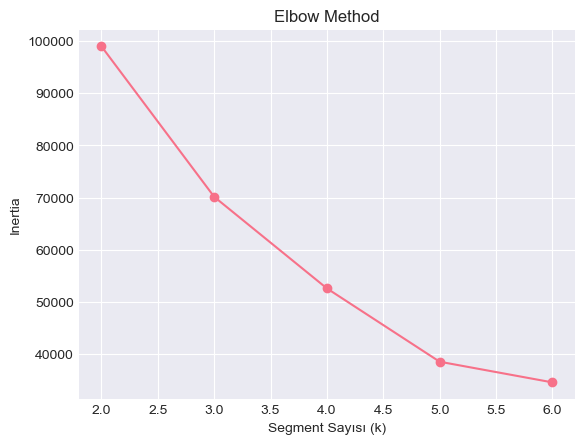

In [401]:
# Küme sayısının belirlenmesi
# Elbow yöntemi ile farklı küme sayıları için inertia değerlerinin hesaplanması

from sklearn.cluster import KMeans

inertias = []

for k in range(2, 7):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

plt.plot(range(2, 7), inertias, marker='o')
plt.xlabel("Segment Sayısı (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.grid(True)
plt.show()

#### Küme Sayısının Belirlenmesi (Elbow Method)
Farklı küme sayıları için modelin **inertia** (küme içi toplam hata) değeri hesaplanmıştır.

Amaç:
- Küme sayısı arttıkça hata azalır
- Ancak azalışın yavaşladığı “dirsek noktası” optimal küme sayısını işaret eder

#### Elbow Grafiğinin Yorumlanması
Grafikte inertia değerlerinin belirli bir noktadan sonra daha sınırlı azaldığı gözlemlenmektedir.
Bu kırılma noktası, veri seti için **anlamlı ve dengeli bir segment sayısını** temsil eder.

In [402]:
# Belirlenen küme sayısı ile KMeans modelinin uygulanması
# Müşterilerin segment etiketlerinin oluşturulması

kmeans = KMeans(n_clusters=4, random_state=42)
musteri_profil['segment'] = kmeans.fit_predict(X_scaled)

musteri_profil['segment'].value_counts()

segment
0    19375
2     7509
3      957
1      449
Name: count, dtype: int64

#### Nihai Segmentasyon
Elbow yöntemi sonucunda belirlenen **4 segment** kullanılarak K-Means modeli uygulanmıştır.

Her müşteriye:
- Tüketim
- Ödeme düzeni
- Gecikme davranışı  

özelliklerine göre bir **segment etiketi** atanmıştır.  
`value_counts()` çıktısı ile segmentlerin müşteri sayıları incelenmiştir.

In [403]:
# Segment bazında temel özet istatistiklerin oluşturulması
segment_ozet = musteri_profil.groupby('segment').agg({
    'ort_tuketim': 'mean',
    'zamaninda_oran': 'mean',
    'ort_gecikme(gun)': 'mean',
    'sozlesme_hesap_no': 'count'
}).round(1)

# Özet tabloda yer alan kolon adlarının düzenlenmesi
segment_ozet.columns = [
    'Ort Tüketim',
    'Zamanında Ödeme %',
    'Ort Gecikme (gün)',
    'Müşteri Sayısı'
]

segment_ozet

,Ort Tüketim,Zamanında Ödeme %,Ort Gecikme (gün),Müşteri Sayısı
segment,,,,
0,52.6,90.8,7.3,19375
1,3144.6,62.8,16.1,449
2,45.5,31.5,45.5,7509
3,20.1,50.3,11.4,957


### Bulgular

- **Ortalama tüketimi yukarı çeken ana unsur**, Segment 1’de yer alan az sayıda fakat çok yüksek tüketimli müşterilerdir.

- **Medyan tüketim değerlerinin görece düşük kalması**, müşteri portföyünün büyük bölümünün Segment 0 ve Segment 2 gibi düşük–orta tüketimli gruplardan oluşmasından kaynaklanmaktadır.

- Tahsilat riski açısından **nicel olarak en kritik segment**, Segment 2’dir.

- **Finansal etki açısından en kritik segment** ise Segment 1’dir.


#### Segment Bazlı Toplulaştırma
Bu adımda, K-Means ile elde edilen segmentler temel alınarak her bir segment için
ortalama müşteri davranışlarını özetleyen istatistikler hesaplanmıştır.

- Ortalama tüketim → segmentin genel kullanım düzeyi  
- Zamanında ödeme oranı → ödeme disiplini  
- Ortalama gecikme süresi → riskli ödeme davranışı  
- Müşteri sayısı → segmentin büyüklüğü  

Bu özet tablo, segmentlerin **birbirinden hangi boyutlarda ayrıştığını** analiz etmek için
temel bir araçtır.

In [405]:
# Segment etiketlerine anlamlı isimlerin atanması
segment_isimleri = {
    0: 'Orta Tüketim ve Düzenli',
    1: 'Yüksek Tüketim - Riskli',
    2: 'Riskli Müşteriler',
    3: 'Düşük Tüketim - İyi'
}

musteri_profil['segment_isim'] = musteri_profil['segment'].map(segment_isimleri)

#### Segment İsimlendirme Mantığı
K-Means algoritması tarafından üretilen sayısal segment etiketleri (0, 1, 2, 3),
analitik olarak anlamlı olmakla birlikte, iş birimleri açısından doğrudan yorumlanabilir değildir.

Bu nedenle segmentler;
- Tüketim düzeyi
- Ödeme disiplini
- Gecikme eğilimi  

gibi özet istatistikler dikkate alınarak, davranışsal profilleri yansıtan
anlamlı isimlerle tanımlanmıştır.

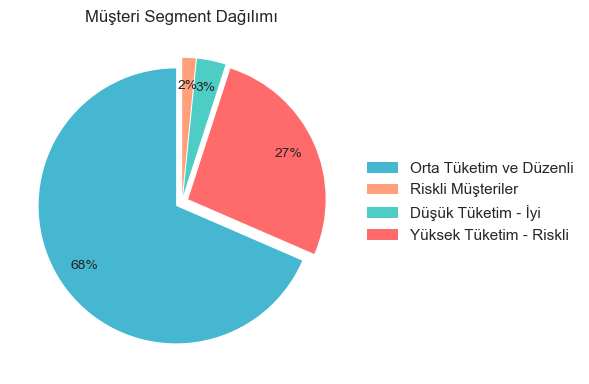

In [495]:
# Müşteri segment dağılımının pasta grafik ile gösterimi

fig, ax = plt.subplots(figsize=(6, 8))

seg_dist = musteri_profil['segment_isim'].value_counts()
colors = ['#45B7D1','#FF6B6B','#4ECDC4','#FFA07A']
explode = [0.05] * len(seg_dist)

plt.pie(seg_dist.values, colors=colors,autopct='%1.f%%', startangle=90,
        pctdistance=0.80, explode = explode)

plt.title("Müşteri Segment Dağılımı")

ax.legend(
    wedges, 
    seg_dist.index,
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=11
)

plt.tight_layout()
plt.savefig('06_musteri_segment_dagılımı.png', dpi=300, bbox_inches='tight')
plt.show()



### Bulgular

Müşteri segment dağılımı incelendiğinde, portföyün büyük ölçüde **düşük ve orta riskli müşterilerden** oluştuğu görülmektedir. 

- **Orta Tüketim ve Düzenli** müşteriler, toplam portföyün yaklaşık **%68’ini** oluşturmaktadır.
- **Riskli Müşteriler**, yaklaşık **%27** ile ikinci en büyük segmenttir.
- **Düşük Tüketim – İyi** segmenti, yaklaşık **%3** gibi sınırlı bir paya sahiptir.
- **Yüksek Tüketim – Riskli** müşteriler ise yalnızca **%2** oranındadır.

Bu dağılım, müşteri portföyünün genel olarak istikrarlı bir yapı sergilediğini, ancak **kayda değer büyüklükte bir riskli müşteri grubunun** da bulunduğunu göstermektedir.


**Özet Bulgular:**

- Portföyün çoğunluğu, düşük riskli ve düzenli müşteriler.  
- Ana risk kaynağı, ödeme davranışından kaynaklı %27’lik riskli müşteri segmentidir.  
- Yapılan yüksek tüketimden kaynaklı, yüksek tüketim – riskli segmenti kritik ve düzenli izlemesi gereken gruptur. 


In [309]:
# İlçe ve segment kırılımında müşteri dağılımının hesaplanması
ilce_seg_dist = musteri_profil.groupby(['ilce', 'segment_isim'],observed=True).size().reset_index(name='count')
ilce_seg_dist

,ilce,segment_isim,count
0,GÖYNÜCEK,Düşük Tüketim - İyi,240
1,GÖYNÜCEK,Orta Tüketim ve Düzenli,4532
2,GÖYNÜCEK,Riskli Müşteriler,2200
3,GÖYNÜCEK,Yüksek Tüketim - Riskli,156
4,GÜMÜŞHACIKÖY,Düşük Tüketim - İyi,614
5,GÜMÜŞHACIKÖY,Orta Tüketim ve Düzenli,12902
6,GÜMÜŞHACIKÖY,Riskli Müşteriler,4407
7,GÜMÜŞHACIKÖY,Yüksek Tüketim - Riskli,258
8,HAMAMÖZÜ,Düşük Tüketim - İyi,103
9,HAMAMÖZÜ,Orta Tüketim ve Düzenli,1941


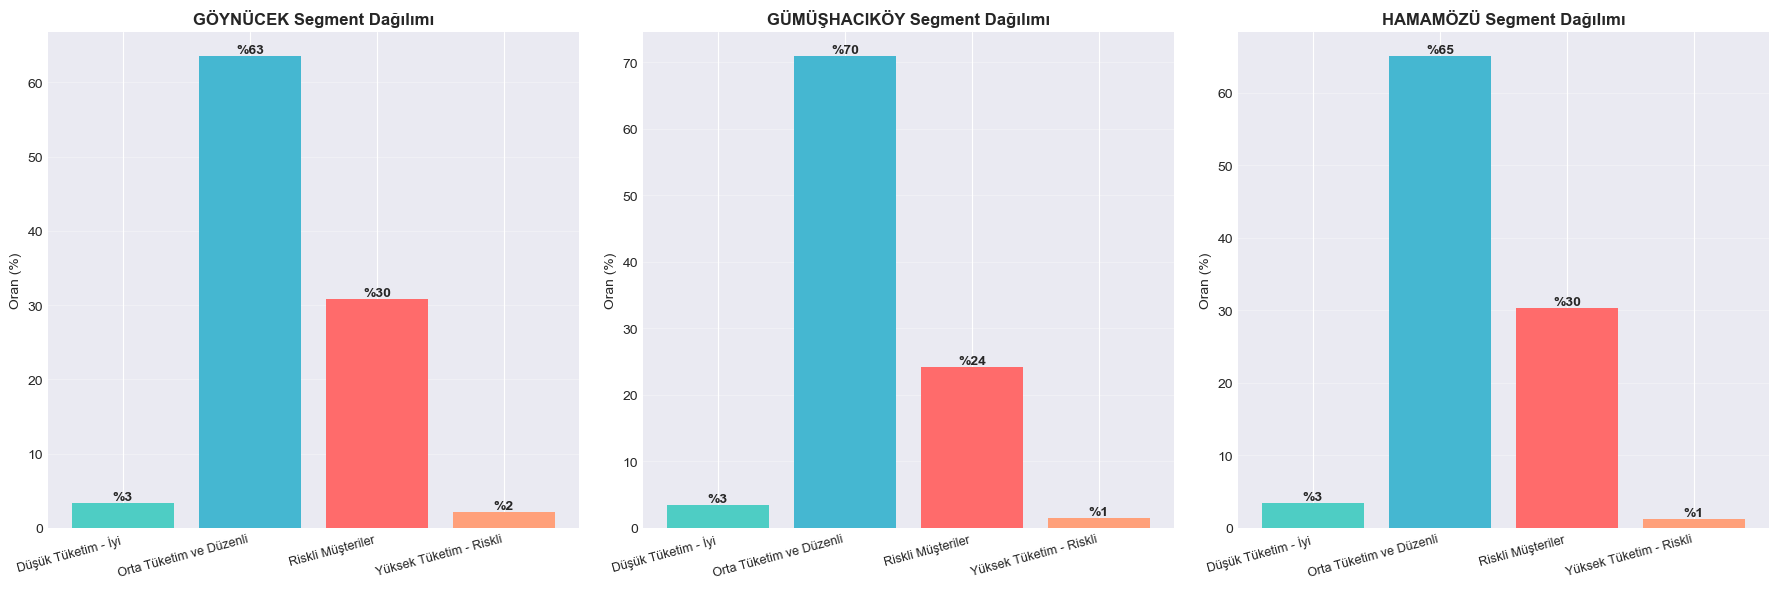

In [498]:
# ilçeler için segment dağılımlarının karşılaştırmalı olarak gösterimi

ilceler = ["GÖYNÜCEK", "GÜMÜŞHACIKÖY", "HAMAMÖZÜ"]
colors = ['#4ECDC4','#45B7D1','#FF6B6B','#FFA07A']

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

for i, ilce_adi in enumerate(ilceler):
     # İlgili ilçe için segment bazlı müşteri sayılarının seçilmesi
    ilce_verisi = ilce_seg_dist[ilce_seg_dist["ilce"] == ilce_adi]
    
    ilce_toplam = ilce_verisi["count"].sum()
    oranlar = (ilce_verisi["count"] / ilce_toplam) * 100
    
    bars = ax[i].bar(ilce_verisi["segment_isim"], oranlar, color=colors)
    
    ax[i].set_title(f'{ilce_adi} Segment Dağılımı', fontweight='bold', fontsize=12)
    ax[i].set_ylabel('Oran (%)')
    ax[i].grid(axis='y', alpha=0.3)
    
    # Segment isimlerinin eksen üzerinde düzenlenmesi
    ax[i].set_xticks(range(len(ilce_verisi["segment_isim"])))  
    ax[i].set_xticklabels(ilce_verisi["segment_isim"],    
                          rotation=15, 
                          ha='right', 
                          fontsize=9)
    
    # Segment bazlı müşteri sayılarının çubuklar üzerinde gösterilmesi
    for bar in bars:
        height = bar.get_height()
        ax[i].text(bar.get_x() + bar.get_width()/2., height,
                   f'%{int(height)}',
                   ha='center', va='bottom', fontweight='bold', fontsize=10)


plt.tight_layout()
plt.savefig('07_ilce_bazlı_segment_dagılımı.png', dpi=300, bbox_inches='tight')
plt.show()


### Bulgular

Göynücek’te riskli müşteri segmentlerinin toplam payı (**%32**), diğer ilçelere kıyasla daha yüksektir. Bu durum, ilçede **ödeme riski yoğunluğunun görece daha belirgin** olduğunu göstermektedir. 

Gümüşhacıköy, üç ilçe arasında **en yüksek düzenli müşteri oranına** sahip ilçedir. Riskli segmentlerin toplam payının (**%25**) görece daha düşük olması, ilçenin **oransal olarak daha dengeli bir müşteri profiline** sahip olduğunu göstermektedir.
  
Hamamözü’nde riskli müşteri oranı (**%31**) Göynücek’e yakın ve benzer yapıya sahip olduğunu gözlenmektedir.
